**Topology**

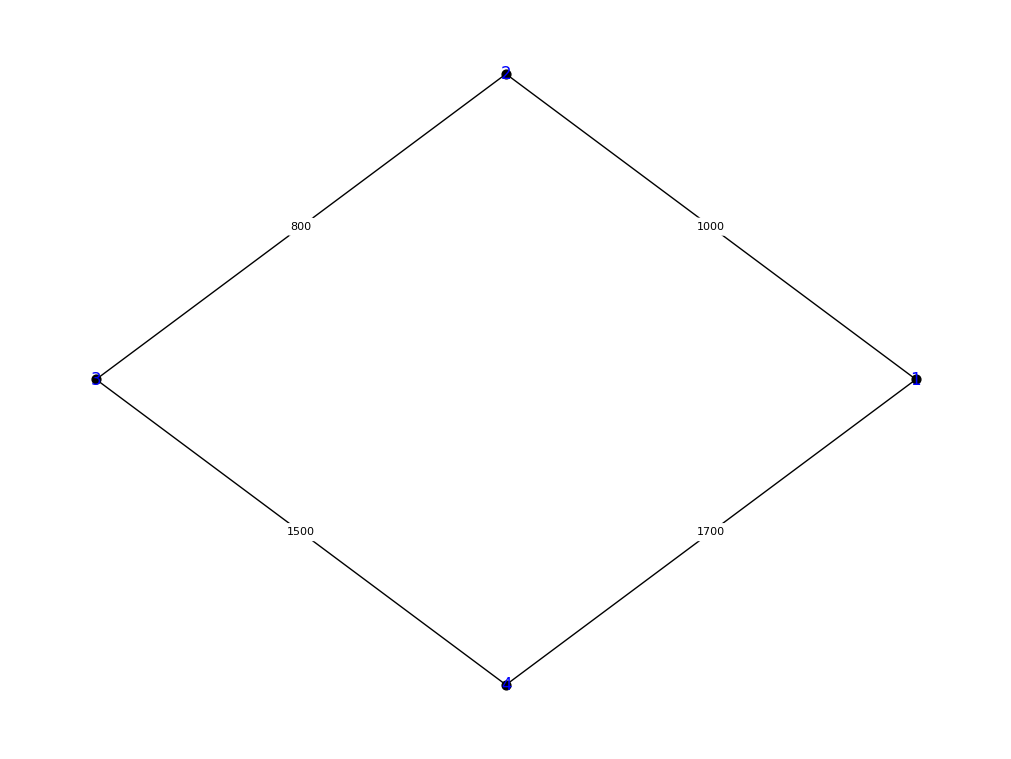

In [ ]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
from typing import Tuple

from optical_networking_gym.topology import Modulation, get_topology

topology_name = "ring_4"

def define_modulations() -> Tuple[Modulation, ...]:
    return (
       Modulation(
            name="BPSK",
            maximum_length=100_000,  # 100,000 km to ensure safety
            spectral_efficiency=1,
            minimum_osnr=12.6,
            inband_xt=-14,
        ),
        Modulation(
            name="QPSK",
            maximum_length=2_000,
            spectral_efficiency=2,
            minimum_osnr=12.6,
            inband_xt=-17,
        ),
        Modulation(
            name="8QAM",
            maximum_length=1_000,
            spectral_efficiency=3,
            minimum_osnr=18.6,
            inband_xt=-20,
        ),
        Modulation(
            name="16QAM",
            maximum_length=500,
            spectral_efficiency=4,
            minimum_osnr=22.4,
            inband_xt=-23,
        ),
        Modulation(
            name="32QAM",
            maximum_length=250,
            spectral_efficiency=5,
            minimum_osnr=26.4,
            inband_xt=-26,
        ),
        Modulation(
            name="64QAM",
            maximum_length=125,
            spectral_efficiency=6,
            minimum_osnr=30.4,
            inband_xt=-29,
        ),
    )
cur_modulations = define_modulations()

topology = get_topology(
        rf"C:\Users\talle\Documents\Mestrado\optical-networking-gym\examples\topologies\{topology_name}.txt",
        "Ring4",                # Name of the topology, adjust if necessary
        cur_modulations,         # Tuple of modulation formats
        80,                      # Maximum span length in km
        0.2,                     # Default attenuation in dB/km
        4.5,                     # Default noise figure in dB
        5                        # Number of shortest paths to compute between node pairs
    )


pos = nx.circular_layout(topology)

labels = {x: f"{y:.0f}" for x, y in nx.get_edge_attributes(topology, "length").items()}

# Plot topology
plt.figure(figsize=(12.8, 9.6))
nx.draw_networkx_nodes(topology, pos=pos, node_color="black", node_size=40)
nx.draw_networkx_labels(topology, pos=pos, labels={x: x for x in topology.nodes()}, font_color="blue")
nx.draw_networkx_edges(topology, pos=pos)
nx.draw_networkx_edge_labels(topology, pos=pos, edge_labels=labels, font_size=8, rotate=False)
plt.axis('off')
plt.show()

In [2]:
import datetime
import os
import time
from optical_networking_gym.heuristics.heuristics import (
    shortest_available_path_first_fit_best_modulation,
    shortest_available_path_lowest_spectrum_best_modulation,
    best_modulation_load_balancing,
    load_balancing_best_modulation,
)

def run_environment(    
    n_eval_episodes,
    heuristic,
    monitor_file_name,
    topology,
    seed,
    allow_rejection,
    load,
    episode_length,
    num_spectrum_resources,
    launch_power_dbm,
    bandwidth,
    frequency_start,
    frequency_slot_bandwidth,
    bit_rate_selection,
    bit_rates,
    margin,
    file_name,
    measure_disruptions,
) -> None:

    env_args = dict(
        topology=topology,
        seed=seed,
        allow_rejection=allow_rejection,
        load=load,
        episode_length=episode_length,
        num_spectrum_resources=num_spectrum_resources,
        launch_power_dbm=launch_power_dbm,
        bandwidth=bandwidth,
        frequency_start=frequency_start,
        frequency_slot_bandwidth=frequency_slot_bandwidth,
        bit_rate_selection=bit_rate_selection,
        bit_rates=bit_rates,
        margin=margin,
        file_name=file_name,
        measure_disruptions=measure_disruptions,
    )

    fn_heuristic = None

    if heuristic == 1:
        fn_heuristic = shortest_available_path_first_fit_best_modulation
    elif heuristic == 2:
        fn_heuristic = shortest_available_path_lowest_spectrum_best_modulation
    elif heuristic == 3:
        fn_heuristic = best_modulation_load_balancing
    elif heuristic == 4:
        fn_heuristic = load_balancing_best_modulation
    else:
        raise ValueError(f"Heuristic index {heuristic} is not found!")

    env = gym.make('QRMSAEnvWrapper-v0', **env_args)

    observation, info = env.reset()

    if monitor_file_name is None:
        raise ValueError("Missing monitor file name")
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    monitor_final_name = "_".join([monitor_file_name, topology.name, str(env.unwrapped.env.launch_power_dbm), str(env.unwrapped.env.load), current_time + ".csv"])
    if os.path.exists(monitor_final_name):
        raise ValueError(f"File {monitor_final_name} already exists!")
    file_handler = open(monitor_final_name, "wt", encoding="UTF-8")
    file_handler.write(f"# Date: {datetime.now()}\n")
    file_handler.write("episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate")
    for mf in env.unwrapped.env.modulations:
        file_handler.write(f",modulation_{mf.spectral_efficiency}")
    file_handler.write(",episode_disrupted_services,episode_time\n")

    for ep in range(n_eval_episodes):
        observation, info = env.reset(options={"only_episode_counters": True})

        done = False
        start_time = time.time()

        while not done:
            action = fn_heuristic(env.unwrapped.env)     
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        end_time = time.time()
        print(info)
        file_handler.write(f"{ep},{info['service_blocking_rate']},{info['episode_service_blocking_rate']},{info['bit_rate_blocking_rate']},{info['episode_bit_rate_blocking_rate']}")
        for mf in env.unwrapped.env.modulations:
            file_handler.write(f",{info[f'modulation_{mf.spectral_efficiency}']}")
        file_handler.write(f",{info['episode_disrupted_services']},{(end_time - start_time):.2f}\n")
    file_handler.close()

    return


** Test Gym Env **

In [ ]:
from datetime import datetime
import random
import time
import gymnasium as gym
import optical_networking_gym.wrappers.qrmsa_gym
from optical_networking_gym.heuristics.heuristics import (
    shortest_available_path_first_fit_best_modulation,
    shortest_available_path_lowest_spectrum_best_modulation,
    best_modulation_load_balancing,
    load_balancing_best_modulation,
)

seed = 20
random.seed(seed)

heuristic = 1
# Parâmetros de simulação
n_eval_episodes = 10
episode_length = 600
load = 210
threads = 1
launch_power = 0

# Parâmetros do espectro
num_slots = 20
frequency_slot_bandwidth = 12.5e9
frequency_start = 3e8 / 1565e-9
bandwidth = num_slots * frequency_slot_bandwidth
frequency_end = frequency_start + bandwidth
bit_rates = (10, 40, 100, 400)
margin = 0

# Defina os argumentos para run_environment
run_env_args = {
    'n_eval_episodes': n_eval_episodes,
    'heuristic': heuristic,
    'monitor_file_name': f"examples/jocn_benchmark_2024/results/load_episodes_{1}",
    'topology': topology,
    'seed': 10,
    'allow_rejection': True,
    'load': 210,
    'episode_length': episode_length,
    'num_spectrum_resources': 20,
    'launch_power_dbm': launch_power,
    'bandwidth': bandwidth,
    'frequency_start': frequency_start,
    'frequency_slot_bandwidth': frequency_slot_bandwidth,
    'bit_rate_selection': "discrete",
    'bit_rates': bit_rates,
    'margin': margin,
    'file_name': f"examples/jocn_benchmark_2024/results/load_services_{1}",
    'measure_disruptions': False,
}

run_environment(**run_env_args)


{'episode_services_accepted': 64, 'service_blocking_rate': 0, 'episode_service_blocking_rate': 0, 'bit_rate_blocking_rate': 0.9744314689612784, 'episode_bit_rate_blocking_rate': 0.9744314689612784, 'disrupted_services': 0.0, 'episode_disrupted_services': 0.0, 'modulation_1': 0, 'modulation_2': 64, 'modulation_4': 0, 'modulation_6': 0}
{'episode_services_accepted': 0, 'service_blocking_rate': 0, 'episode_service_blocking_rate': 1, 'bit_rate_blocking_rate': 0.9873487014171888, 'episode_bit_rate_blocking_rate': 1.0, 'disrupted_services': 0.0, 'episode_disrupted_services': 0.0, 'modulation_1': 0, 'modulation_2': 0, 'modulation_4': 0, 'modulation_6': 0}
{'episode_services_accepted': 0, 'service_blocking_rate': 0, 'episode_service_blocking_rate': 1, 'bit_rate_blocking_rate': 0.9917987540414793, 'episode_bit_rate_blocking_rate': 1.0, 'disrupted_services': 0.0, 'episode_disrupted_services': 0.0, 'modulation_1': 0, 'modulation_2': 0, 'modulation_4': 0, 'modulation_6': 0}
{'episode_services_acce

: 